In [122]:
import numpy as np
from PIL import Image
from io import BytesIO
from IPython.display import display
import os
from google.cloud import vision, storage
from tqdm.notebook import tqdm
import webcolors
import hashlib
import pymongo
import glob
import datetime
import decouple

config = decouple.AutoConfig(' ')
dir_from = 'imgs/origin/'
dir_archive = 'imgs/archive/'
dir_desc = 'imgs/desc/'
bucket_name = 'sideb-proejct.appspot.com'
bucket_dir = 'piixur/'

In [123]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = os.path.abspath(os.path.join(os.getcwd(), 'config/sideb-proejct-0e33d8c0b0a9.json'))

In [124]:
storage_client = storage.Client()
buckets = list(storage_client.list_buckets())
buckets

[<Bucket: gcf-sources-630659159765-us-central1>,
 <Bucket: sideb-proejct.appspot.com>,
 <Bucket: staging.sideb-proejct.appspot.com>,
 <Bucket: us.artifacts.sideb-proejct.appspot.com>]

In [125]:
mongo = pymongo.MongoClient(config('MONGODB_URI'))
db = mongo.Cluster0
colpix = db.pix

colpix.create_index('hash', unique=True)
colpix.create_index([('labels', 'text')])
colpix.index_information()

{'_id_': {'v': 2, 'key': [('_id', 1)]},
 'hash_1': {'v': 2, 'key': [('hash', 1)], 'unique': True},
 'labels_text': {'v': 2,
  'key': [('_fts', 'text'), ('_ftsx', 1)],
  'weights': SON([('labels', 1)]),
  'default_language': 'english',
  'language_override': 'language',
  'textIndexVersion': 3}}

In [126]:
class Pix:
    def __init__(self, imgpath):
        self.imgpath = imgpath
        self.fname = imgpath.split('/')[-1]
        self.ext = imgpath.split('.')[-1]
        self.vision_client = vision.ImageAnnotatorClient()
        self.storage_client = storage.Client()
        
        self.image = self.get_image()
        self.hash = self.hashing()
        
        self.resp_label = None
        self.resp_web = None
        self.resp_prop = None

        self.labels = None
        self.urls = None
        self.colors = None
        
        self.analyze()
        
        
    def get_image(self):
        with open(self.imgpath, 'rb') as img_file:
            content = img_file.read()

        return vision.Image(content=content)       
        
        
    def show(self):
        # display(Image.open(BytesIO(self.image.content)))
        display(Image.open(self.imgpath))

        
    def analyze(self):
        if colpix.find_one({'hash': self.hash}):
            print('이미 있네: ' + self.hash)
            return
        
        self.labels = self.annotate_label()
        self.urls = self.find_url()
        self.colors = self.extract_color()
        
        if len(self.urls) > 0:
            self.save_to_mongo()
            self.archive()
            self.upload_to_gcs()
            
        else:
            print('소스가 없네: ' + self.hash)
            return
        
        
    def annotate_label(self, min_score=0.6):
        self.resp_label = self.vision_client.label_detection(image=self.image, max_results=50)
        labels = self.resp_label.label_annotations
        labels = [label.description.lower().replace(' ', '_') for label in labels if label.score>=min_score]
        return ' '.join(labels)
        
        
    def urls_from_desc(self):
        try:
            with open(dir_desc + self.fname + '.url.txt', 'r') as file:
                _url = file.read()
            return [ _url ]

        except:
            return []

        
    def urls_from_google(self):
        try:
            self.resp_web = self.vision_client.web_detection(image=self.image)
            
            if self.resp_web.web_detection.full_matching_images:
                return [img.url for img in self.resp_web.web_detection.full_matching_images]
            
            else:
                return [img.url for img in self.resp_web.web_detection.partial_matching_images]
        
        except:
            return []
        
        
    def find_url(self):
        _urls_from_desc = self.urls_from_desc()
        _urls_from_google = self.urls_from_google()
        
        if self.ext == 'gif':
            return _urls_from_desc + _urls_from_google
            
        else:
            return _urls_from_google + _urls_from_desc
        
        
    def extract_color(self, pct_thres=0.6):
        self.resp_props = self.vision_client.image_properties(image=self.image)
        dom_colors = self.resp_props.image_properties_annotation.dominant_colors.colors

        pct_cum = 0
        colors = []
        score_sum = sum([clr.score for clr in dom_colors])

        # for clr in sorted(dom_colors, key=lambda x: -x.score): 
        # socore 기준 sort가 능사는 아니다. pixel_fraction도 중요하므로
        for clr in dom_colors:
            if pct_cum > pct_thres: 
                break

            pct_cum += (clr.score / score_sum)
            colors.append(self.get_color_name((clr.color.red, clr.color.green, clr.color.blue)))

        return ' '.join(colors)
        
        
    def hashing(self):
        _img = Image.open(self.imgpath).convert('RGB')
        _img_array = np.array(_img).astype(np.uint16)
        _img_bytes = _img_array.tobytes()
        return hashlib.sha256(_img_bytes).hexdigest()
        
        
    def closest_color(self, requested_color):
        min_colors = {}

        for key, name in webcolors.CSS21_HEX_TO_NAMES.items():
            r_c, g_c, b_c = webcolors.hex_to_rgb(key)
            rd = (r_c - requested_color[0]) ** 2
            gd = (g_c - requested_color[1]) ** 2
            bd = (b_c - requested_color[2]) ** 2
            min_colors[(rd + gd + bd)] = name

        return min_colors[min(min_colors.keys())]

    
    def get_color_name(self, requested_color):
        try:
            closest_name = webcolors.rgb_to_name(requested_color, spec='css21')

        except ValueError:
            closest_name = self.closest_color(requested_color)
            actual_name = None

        return closest_name
    
    
    def save_to_mongo(self):
        pix = {
            'labels': self.labels,
            'urls': self.urls,
            'colors': self.colors,
            'hash': self.hash,
            'created_at': datetime.datetime.utcnow()
        }
        return colpix.insert_one(pix).inserted_id
    
    
    def archive(self):
        imgpath_new = dir_archive + self.hash + '.' + self.ext
        os.rename(self.imgpath, imgpath_new)
        self.imgpath = imgpath_new
        
        
    def upload_to_gcs(self):
        destination_blob_name = bucket_dir + self.hash + '.' + self.ext
        blob = self.storage_client.bucket(bucket_name).blob(destination_blob_name)
        blob.upload_from_filename(self.imgpath)

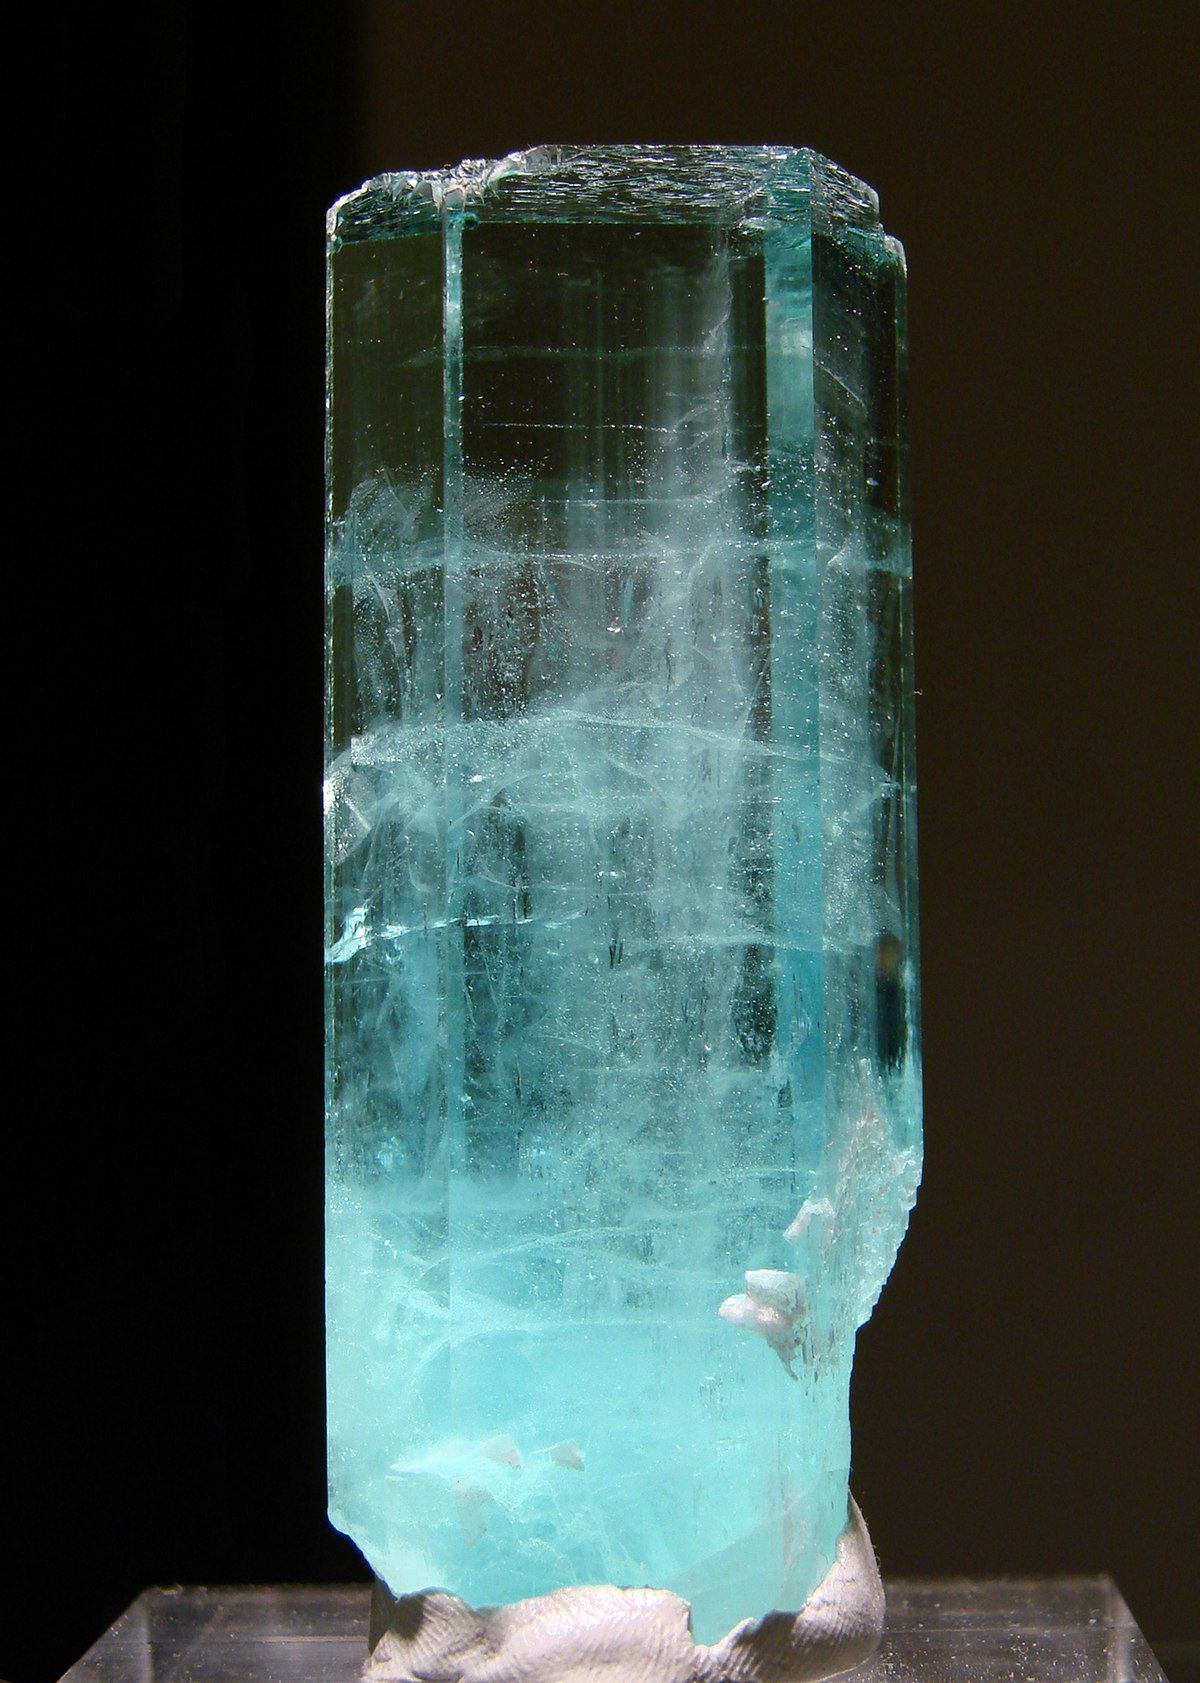

In [56]:
pix = Pix('imgs/origin/en.wikipedia.org FileAigue-marine-Pakistan-180308jpg-Wikiped31f555ddc4928875d581a9d94e6ce04b.jpg')
pix.show()

In [42]:
pix.labels

In [43]:
pix.urls

In [10]:
pix.hash

'28235e860e2cbab447741de817d6d6bf6cd43839c3a87b14a61e5dbf87379ade'

In [11]:
pix.colors

In [12]:
pix.imgpath

'imgs/origin/2087.tumblr.com -Photo52562cba1ffaf3cefc498d81b37299ca.jpg'

In [47]:
pix.upload_to_gcs()

In [131]:
glob.glob(dir_from + '*.*')

['imgs/origin/woahdudenode.tumblr.com Woahdude1285bb795e25df2eff41b09bfb7f822a.gif',
 'imgs/origin/thetentaclesoflife.tumblr.com The-tentacles-of-Life0f1a46aa48ecba9e6e8618c9e85f6b9c.jpg',
 'imgs/origin/vulcanvakarian.tumblr.com vulcanvakarianf25f17143ff35243507aaa742647fac7.gif',
 'imgs/origin/thetentaclesoflife.tumblr.com The-tentacles-of-Life1e64db8af5760fc7c582cb86e3c12d31.jpg',
 'imgs/origin/inferior.tumblr.com Inferior54b3345c3faa5b362a39b7a30e43dfe6.png',
 'imgs/origin/furtho.tumblr.com the-track-east833f646c9e59d1c1f18edd2c70aa6703.jpg',
 'imgs/origin/Uploaded by user gem7630030 -f99688b471c88e7bbd564a067b15d54a.jpg',
 'imgs/origin/enigmaticsparrow.tumblr.com ENIGMATICSPARROW-Photo940781da8735c484ce44ba3c45ab4cfd.jpg',
 'imgs/origin/subdub.tumblr.com SUBDUB-Photoa42362d89e49f2849ece8ebc226a576a.jpg',
 'imgs/origin/thetentaclesoflife.tumblr.com The-tentacles-of-Life876bb321407486aac852006a74954a7e.jpg',
 'imgs/origin/furtho.tumblr.com the-track-east764a5a856758a7296fea6e76ce4663

In [132]:
pixs = {}

for _fname in tqdm(glob.glob(dir_from + '*.*')):
    _pix = Pix(_fname)
    pixs[_pix.hash] = _pix

  0%|          | 0/101 [00:00<?, ?it/s]

In [108]:
pixs['e72190fb04445540835f332bc2650cba7cf9712ec40c55a7cedae70725f075e6'].urls

['https://understands.tumblr.com/image/674597933159792640',
 'https://64.media.tumblr.com/caad5ec576fa5c724faadf7622f0d070/tumblr_pq38aldfXg1vnzuir_540.gifv',
 'https://hygall.com/download/85876939/fef78a2b4c3890dc3d171dd48e4f5d7a/68BBACC0-A82E-4BEB-ADF1-49C21B330181.gif',
 'https://64.media.tumblr.com/daef5045daa3d1ecb4d47f67ade2b5df/tumblr_ork9tzd55z1ws7znjo1_540.gifv',
 'https://pbs.twimg.com/tweet_video_thumb/En_scgpXEAE8FRf.jpg',
 'https://mblogthumb-phinf.pstatic.net/20160624_13/dusdubin114_1466766653906YluyJ_GIF/tumblr_o8jhj6N8qe1udy8ezo1_500.gif?type=w2',
 'https://78.media.tumblr.com/daef5045daa3d1ecb4d47f67ade2b5df/tumblr_ork9tzd55z1ws7znjo1_500.gifv',
 'https://64.media.tumblr.com/daef5045daa3d1ecb4d47f67ade2b5df/tumblr_ork9tzd55z1ws7znjo1_400.gifv',
 'https://data.whicdn.com/images/325977730/original.gif']

In [114]:
pixs['e2514503e9787dbdf4a916b66562ed6e8da447459fe0ec54d82e12c6fdc633ae'].urls_from_desc()

['https://qualisign.tumblr.com/image/177311145029']

In [115]:
pixs['e2514503e9787dbdf4a916b66562ed6e8da447459fe0ec54d82e12c6fdc633ae'].urls

['https://qualisign.tumblr.com/image/177311145029']

In [18]:
blobs = list(storage_client.list_blobs(bucket_name, prefix='piixur')); blobs

[<Blob: sideb-proejct.appspot.com, piixur/, 1656317984648662>,
 <Blob: sideb-proejct.appspot.com, piixur/test.jpg, 1656318273466325>]

In [53]:
blobs = list(storage_client.list_blobs(bucket_name, prefix='piixur/0a413b2e8e26684de2ed1d060dfdc3e79d999640e3722e1ec198bbc6446fb766')); blobs

[<Blob: sideb-proejct.appspot.com, piixur/0a413b2e8e26684de2ed1d060dfdc3e79d999640e3722e1ec198bbc6446fb766.jpg, 1656323203779479>]

In [57]:
bucket = storage_client.get_bucket(bucket_name); bucket

<Bucket: sideb-proejct.appspot.com>

In [70]:
blob = bucket.get_blob('piixur/0a413b2e8e26684de2ed1d060dfdc3e79d999640e3722e1ec198bbc6446fb766.jpg'); blob

<Blob: sideb-proejct.appspot.com, piixur/0a413b2e8e26684de2ed1d060dfdc3e79d999640e3722e1ec198bbc6446fb766.jpg, 1656323203779479>

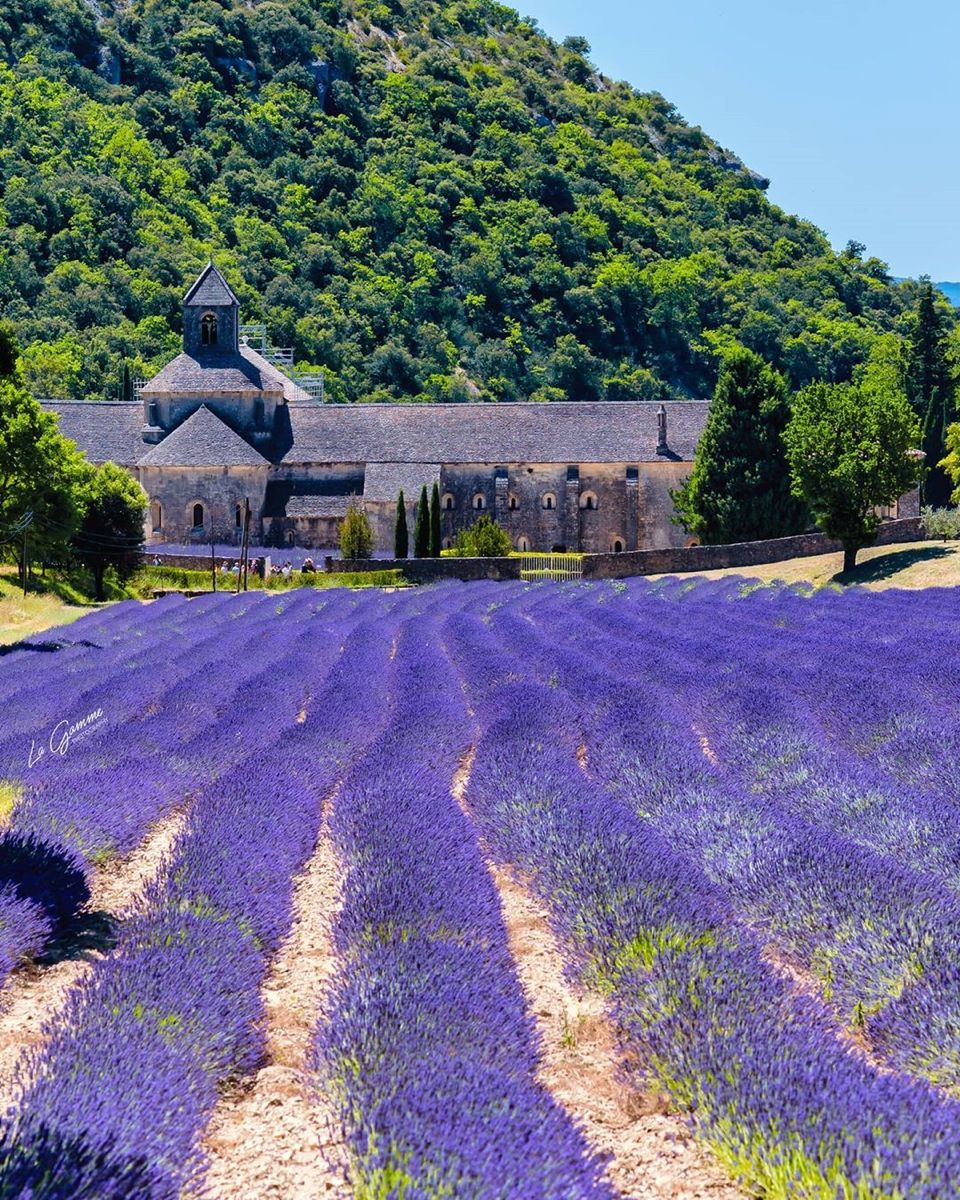

In [81]:
Image.open(BytesIO(blob.download_as_bytes()))

In [64]:
len(list(storage_client.list_blobs(bucket_name, prefix='piixur')))

348

In [98]:
[3] + [1,9]

[3, 1, 9]